In [1]:
from transforms import *
from torchvision.transforms import *
import librosa
import utils.config as config
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from functools import partial
from datasets.librispeech import convert_to_mel
import soundfile
import resampy

def tensor_to_img(spectrogram):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.tight_layout()

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [2]:
# audio_path = '/Users/vigi99/AirtelDEV/VoiceDataForAirtel/CommonCorpusTest/sample-114726.wav'
audio_path = '/Users/vigi99/AirtelDEV/VoiceDataForAirtel/CommonCorpusTest/sample-168820.wav'
audio, original_sampling_rate = soundfile.read(audio_path, dtype='float32')
audio = resampy.resample(audio, 16000, original_sampling_rate, axis=-1)
# audio, _ = librosa.core.load(audio_path, sr=16000)
data = {'samples': audio, 'sample_rate': config.sampling_rate, 'epoch': 0}

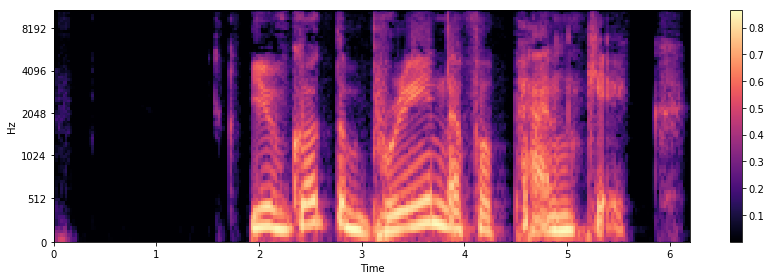

In [3]:
def get_mel(audio):
    return convert_to_mel(audio.reshape(1, -1))

spec_dctts = get_mel(audio)
tensor_to_img(spec_dctts)

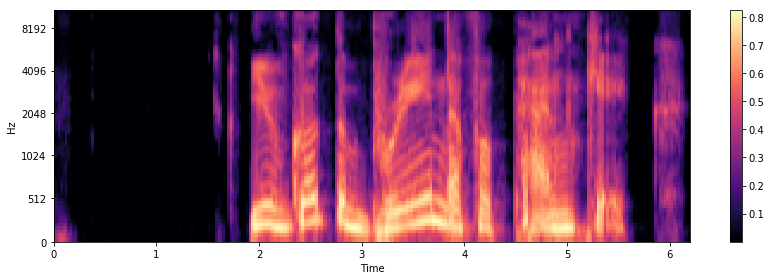

In [6]:
def convert_to_mel2(signal):
    data = {'samples': signal.squeeze(0), 'sample_rate': config.sampling_rate}
    to_stft = ToSTFT(n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.window_length)
    convert_to_mel = ToMelSpectrogramFromSTFT(n_mels=config.num_mel_banks)
    transforms = Compose([to_stft, convert_to_mel, DeleteSTFT(), ToAudioTensor(['mel_spectrogram'])])
    return transforms(data)

def image_train_transform(signal, epoch=100):
    data = {'mel_spectrogram': convert_to_mel2(signal), 'sample_rate': config.sampling_rate, 'epoch': epoch}
    transforms = Compose([SpecBlurring(), ToAudioTensor(['mel_spectrogram'])])
    return transforms(data)

signal = audio.reshape(1, -1)
spec_dctts = image_train_transform(signal)
tensor_to_img(spec_dctts)

In [7]:
def blur_signal(signal):
    data = {'samples': signal.squeeze(0), 'sample_rate': config.sampling_rate}
    to_stft = ToSTFT(n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.window_length)
    transforms = Compose([to_stft, SpecNoise(type='stft'), ToAudioTensor(['stft'])])
    blurred_spec = transforms(data)
    blurred_signal = librosa.core.istft(blurred_spec, hop_length=config.hop_length, win_length=config.window_length)
    return blurred_signal

In [8]:
import IPython.display as ipd
ipd.Audio(signal, rate=config.sampling_rate)

In [11]:
blurred_signal = blur_signal(signal)
ipd.Audio(blurred_signal, rate=config.sampling_rate)